In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import random
from torch.utils.data import Dataset,sampler,DataLoader
import torch
import torch.nn as nn
from tqdm import tqdm

In [2]:
from data_functions import *
from models import es_rnn,holt_winters_no_trend

In [3]:
series = [30,21,29,31,40,48,53,47,37,39,31,29,17,9,20,24,27,35,41,38,
          27,31,27,26,21,13,21,18,33,35,40,36,22,24,21,20,17,14,17,19,
          26,29,40,31,20,24,18,26,17,9,17,21,28,32,46,33,23,28,22,27,
          18,8,17,21,31,34,44,38,31,30,26,32]

In [17]:
df = pd.read_csv('../datasets/weather_energy_hourly.csv')

In [20]:
series = df.avg_energy.tolist()

In [ ]:
train=series[:-12]
test=series

In [ ]:
sl

In [ ]:
sl=sequence_labeling_dataset(train,1000,False)
sl_t=sequence_labeling_dataset(test,1000,False)

train_dl= DataLoader(dataset=sl,
                      batch_size=512,
                      shuffle=False)

test_dl= DataLoader(dataset=sl_t,
                      batch_size=512,
                      shuffle=False)

In [ ]:
train_dl

In [ ]:
hw=es_rnn()

In [21]:
train=series[:-12]
test=series

In [15]:
sl

In [22]:
sl=sequence_labeling_dataset(train,1000,False)
sl_t=sequence_labeling_dataset(test,1000,False)

train_dl= DataLoader(dataset=sl,
                      batch_size=512,
                      shuffle=False)

test_dl= DataLoader(dataset=sl_t,
                      batch_size=512,
                      shuffle=False)

In [23]:
train_dl

In [24]:
hw=es_rnn()

In [25]:
opti = torch.optim.Adam(hw.parameters(), lr=0.01)#,weight_decay=0.0001

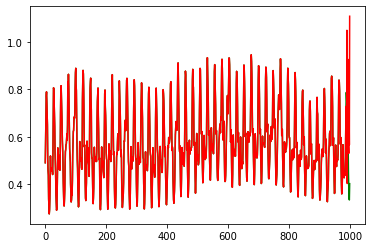

In [26]:
#Initial Prediction 

overall_loss=[]
batch=next(iter(test_dl))
inp=batch[0].float()#.unsqueeze(2)
out=batch[1].float()#.unsqueeze(2).float()
shifts=batch[2].numpy()
pred=hw(inp,shifts)
plt.plot(torch.cat([inp[0],out[0,:]]).detach().numpy(),"g")
plt.plot(torch.cat([inp[0],pred[0,:]]).detach().numpy(),"r")
plt.show()

In [27]:
#Initial Loss RMSE 
(torch.mean((pred-out)**2))**(1/2)

tensor(0.2923, grad_fn=<PowBackward0>)

In [28]:
#Baseline Loss Predicting last value at each step
(torch.mean((inp[0][-1]-out)**2))**(1/2)

tensor(0.3287)

In [29]:
overall_loss_train=[]
overall_loss=[]

In [ ]:
for j in tqdm(range(20)):
    loss_list_b=[]
    train_loss_list_b=[]
    #here we use batches of past, and to be forecasted value
    #batches are determined by a random start integer
    for batch in iter(train_dl):

        opti.zero_grad()
        inp=batch[0].float()#.unsqueeze(2)
        out=batch[1].float()#.unsqueeze(2).float()
        shifts=batch[2].numpy()
        #it returns the whole sequence atm 
        pred=hw(inp,shifts)
        loss=(torch.mean((pred-out)**2))**(1/2)
        train_loss_list_b.append(loss.detach().cpu().numpy())
        
        loss.backward()
        opti.step()


    #here we use all the available values to forecast the future ones and eval on it
    for batch in iter(test_dl):
        inp=batch[0].float()#.unsqueeze(2)
        out=batch[1].float()#.unsqueeze(2).float()
        shifts=batch[2].numpy()
        pred=hw(inp,shifts)
        #loss=torch.mean(torch.abs(pred-out))
        loss=(torch.mean((pred-out)**2))**(1/2)
        loss_list_b.append(loss.detach().cpu().numpy())
    
 
    print(np.mean(loss_list_b))
    print(np.mean(train_loss_list_b))
    overall_loss.append(np.mean(loss_list_b))
    overall_loss_train.append(np.mean(train_loss_list_b))

  5%|██████▋                                                                                                                              | 1/20 [00:43<13:44, 43.38s/it]

0.18803158
0.22542596


 10%|█████████████▎                                                                                                                       | 2/20 [01:29<13:15, 44.19s/it]

0.16793439
0.17662525


 15%|███████████████████▉                                                                                                                 | 3/20 [02:16<12:44, 44.96s/it]

0.09404652
0.14156424


In [ ]:
#Plot of Train and Validatiaon Loss, we nicely converge
plt.plot(overall_loss,"g")
plt.plot(overall_loss_train,"r")

In [ ]:
#Forecasting on the Validation set

batch=next(iter(test_dl))
inp=batch[0].float()#.unsqueeze(2)
out=batch[1].float()#.unsqueeze(2).float()
shifts=batch[2].numpy()
pred=hw(torch.cat([inp,out],dim=1),shifts)

#plt.plot(torch.cat([inp,out,pred],dim=1)[0].detach().numpy(),"r")


plt.plot(torch.cat([inp[0],out[0,:]]).detach().numpy(),"g")
plt.plot(torch.cat([inp[0],pred[0,:]]).detach().numpy(),"r")
plt.show()

In [ ]:
#Forecasting to the Future looks good.

batch=next(iter(test_dl))
inp=batch[0].float()#.unsqueeze(2)
out=batch[1].float()#.unsqueeze(2).float()
shifts=batch[2].numpy()

pred=hw(torch.cat([inp,out],dim=1),shifts)
plt.plot(torch.cat([inp,out],dim=1)[0].detach().numpy(),"b")
plt.plot(torch.cat([inp,out,pred],dim=1)[0].detach().numpy(),"r")


plt.show()

In [ ]:
param_list=[]
for params in hw.parameters():
    param_list.append(params)
param_list=torch.sigmoid(params[0:2]).detach().numpy()

param_list